In [34]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [35]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R11/'; 
Target  = 'CrateScan/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [36]:
# Define 3 models: normal DFN, single transport by high Dec, double transport
Model_DFN  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,}) 
Model_SD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "full"  ,}) 
Model_DD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "sol full"  ,}) 
Model_All =[ Model_DFN,  Model_SD, Model_DD ]
Str_model =[ 'Model_DFN',  'Model_SD', 'Model_DD' ]
# 3 parameter set: Andrew, constant. Valoen
Para_All = []
for i in range(1,4):
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC Lithium ion cross diffusivity [m2.s-1]":1.5e-12})
    para.update({"EC initial concentration in electrolyte [mol.m-3]":6250})
    para.update({"Cation transference number":t_0plus_constant})
    Para_All.append(para)
Para_All[0].update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_Andrew2022})
Para_All[0].update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_Valoen2005Constant})
Para_All[1].update({"Electrolyte conductivity [S.m-1]":cond_constant})
Para_All[1].update({"Electrolyte diffusivity [m2.s-1]":diff_constant})
Para_All[2].update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_Valoen2005Constant})
Para_All[2].update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_Valoen2005Constant})
Str_para = ['Andrew', 'Constant', 'Valoen']

In [66]:
def Run_P3_OneCycle(Rate_Dis,Rate_Cha,model,para,str_model,str_para):
    para_used = para.copy()
    if (
        model.options["solvent diffusion"]=="double spatial consume w refill" 
        and 
        model.options["electrolyte conductivity"]=='full'):
        para_used.update({"EC diffusivity in electrolyte [m2.s-1]":EC_diffusivity_5E_5})
        print('Using EC_diffusivity_5E_5')
    V_max = 4.2;        V_min = 2.5
    if Rate_Dis > 4:
        ts_dis = 1
    else: 
        ts_dis = 20
    if Rate_Cha > 4:
        ts_cha = 1
    else:
        ts_cha = 20
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/100",
        f"Discharge at {Rate_Dis} C until {V_min} V ({ts_dis} second period)", 
        f"Charge at {Rate_Cha} C until {V_max} V ({ts_cha} second period)", 
        f"Hold at {V_max} V until C/100")    ] * 1 )  

    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para_used["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para_used["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para_used["Electrolyte conductivity [S.m-1]"]
    Xi = para_used["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    t_0plus = para_used["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),)       
    sol    = sim.solve()
    MyDict = {}
    try:
        MyDict ['Discharge Capacity'] = abs(
            sol.cycles[0].steps[1]['Discharge capacity [A.h]'].entries[0] - 
            sol.cycles[0].steps[1]['Discharge capacity [A.h]'].entries[-1] )
    except:
        MyDict ['Discharge Capacity'] = 0
    else:
        pass
    try:
        MyDict ['Charge Capacity'] = abs(
            sol.cycles[0].steps[2]['Discharge capacity [A.h]'].entries[0] - 
            sol.cycles[0].steps[3]['Discharge capacity [A.h]'].entries[-1] )#
    except:
        MyDict ['Charge Capacity']    = 0
    else:
        pass
    MyDict['Solution']  = sol
    MyDict['Rate_Dis']  = Rate_Dis
    MyDict['Rate_Cha']  = Rate_Cha
    return MyDict
    
def Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para):   
    Case_Dict = {}
    MyDict_All =[]; Cap_Dis_All = []  ; Cap_Cha_All = []  
    # scan C-rate
    for Rate_Dis in Rate_Dis_All:
        for Rate_Cha in Rate_Cha_All:
            MyDict_All.append(
                Run_P3_OneCycle(
                    Rate_Dis,Rate_Cha,model,para,
                    str_model,str_para))
            Cap_Dis_All.append(MyDict_All[-1]['Discharge Capacity'])
            Cap_Cha_All.append(MyDict_All[-1]['Charge Capacity'])
    Case_Dict ['Cap_Dis_All'] = Cap_Dis_All
    Case_Dict ['Cap_Cha_All'] = Cap_Cha_All
    Case_Dict ['str_model'] = str_model
    Case_Dict ['str_para']  = str_para
    Case_Dict ['MyDict_All']  = MyDict_All
    Case_Dict ['Rate_Dis_All']  = Rate_Dis_All
    Case_Dict ['Rate_Cha_All']  = Rate_Cha_All
    return Case_Dict

def Plot_quick(Case_Para_All, Crate_i, fs):
    font = {'family' : 'DejaVu Sans','size'   : fs}; mpl.rc('font', **font)
    label = ["Normal DFN","Single transport","Double transport",] 
    output_variables3 = [
        #"X-averaged battery open circuit voltage [V]",
        "Battery voltage [V]",
        "X-averaged battery reaction overpotential [V]",
        "X-averaged battery concentration overpotential [V]",
        "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
        "X-averaged battery electrolyte ohmic losses [V]",
        "X-averaged battery solid phase ohmic losses [V]",
    ]
    quick_plot = pybamm.QuickPlot(
        [
            Case_Para_All[i]['MyDict_All'][Crate_i]['Solution'].cycles[0].steps[1] for i in range(0,3)
        ], 
        output_variables3,label,variable_limits='tight',
        time_unit='hours',
        spatial_unit='mm', figsize = (9,7),    #  (“m”, “mm”, or “um”)
        n_rows=2) #
    quick_plot.dynamic_plot()

    output_variables3 = [
        "Electrolyte potential [V]",
        "EC concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "EC transference number",
        "Electrolyte conductivity [S.m-1]",
        "Electrolyte diffusivity [m2.s-1]",
    ]
    quick_plot = pybamm.QuickPlot(
        [
            Case_Para_All[i]['MyDict_All'][Crate_i]['Solution'].cycles[0].steps[1] for i in range(0,3)
        ], 
        output_variables3,label,variable_limits='fixed',
        time_unit='hours',
        spatial_unit='mm', figsize = (9,7),     #  (“m”, “mm”, or “um”)
        n_rows=2) #figsize = (18,12),
    quick_plot.dynamic_plot()

In [26]:
Rate_Dis_All = [0.5,1,2,3,4,5,6,7,8,9,10];  Rate_Cha_All = [1,]
# Str_para = ['Andrew', 'Constant', 'Valoen']
Andrew_All = []; para = Para_All[0]; str_para = Str_para[0];
for model,str_model in zip(Model_All,Str_model):
    Andrew_All.append(
        Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para)
        )

At t = 0.00838047, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00568533 and h = 5.00099e-025, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00646761 and h = 3.38768e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00558381 and h = 7.37994e-020, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00737611 and h = 1.16351e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00516548 and h = 2.3248e-020, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


At t = 0.00838048 and h = 3.88605e-019, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5


At t = 0.00568533 and h = 2.27066e-018, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5


At t = 0.00643002 and h = 7.30166e-020, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00558384 and h = 7.35429e-023, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00737612 and h = 8.87327e-023, the corrector convergence failed repeatedly or with |h| = hmin.
The linesearch algorithm failed with too small a step.


Using EC_diffusivity_5E_5


At t = 0.00516548 and h = 3.45171e-020, the corrector convergence failed repeatedly or with |h| = hmin.
The linesearch algorithm failed with too small a step.
At t = 0.00838559, , mxstep steps taken before reaching tout.
At t = 0.00663567 and h = 2.56837e-023, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00709142 and h = 7.3321e-023, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00565132 and h = 2.6265e-023, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00738191 and h = 5.42574e-021, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00514029 and h = 1.00239e-021, the corrector convergence failed repeatedly or with |h| = hmin.


In [27]:
Constant_All = []; para = Para_All[1]; str_para = Str_para[1];
for model,str_model in zip(Model_All,Str_model):
    Constant_All.append(
        Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para)
        )

At t = 0.00837673, , mxstep steps taken before reaching tout.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_

Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


At t = 0.00837672 and h = 8.53022e-018, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Using EC_diffusivity_5E_5


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Using EC_diffusivity_5E_5


At t = 0.00260706 and h = 1.95752e-011, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00261107 and h = 2.04753e-011, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00838219 and h = 3.41818e-018, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00133163, , mxstep steps taken before reaching tout.
At t = 0.00133163, , mxstep steps taken before reaching tout.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../

In [56]:
Valoen_All = []; para = Para_All[2]; str_para = Str_para[2];
for model,str_model in zip(Model_All,Str_model):
    Valoen_All.append(
        Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para)
        )

At t = 0.00838275, , mxstep steps taken before reaching tout.
At t = 0.00133219, , mxstep steps taken before reaching tout.
At t = 0.00133219, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00774026 and h = 4.41215e-011, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00297353 and h = 2.51771e-011, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


At t = 0.00838276, , mxstep steps taken before reaching tout.
At t = 0.0013322, , mxstep steps taken before reaching tout.
At t = 0.0013322 and h = 7.26274e-019, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5
Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00814256 and h = 1.5189e-013, the corrector convergence failed repeatedly or with |h| = hmin.


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00787979 and h = 2.37325e-011, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00486724 and h = 3.56678e-011, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed:

Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.008837 and h = 1.80143e-013, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


Using EC_diffusivity_5E_5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00270385 and h = 1.57651e-011, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00270608 and h = 5.42534e-013, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00838787, , mxstep steps taken before reaching tout.
At t = 0.00133731, , mxstep steps taken before reaching tout.
At t = 0.00133731, , mxstep steps taken before reaching tout.
At t = 8.73123e-005, , mxstep steps taken before reaching tout.
At t = 8.73124e-005, , mxstep steps taken before reaching tout.
At t = 8.73123e-005 and h = 1.51178e-018, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 8.73123e-005, , mxstep steps taken before reaching tout.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
At

Text(0.5, 1.0, '$D_e = Valoen, \\sigma_e=Valoen$')

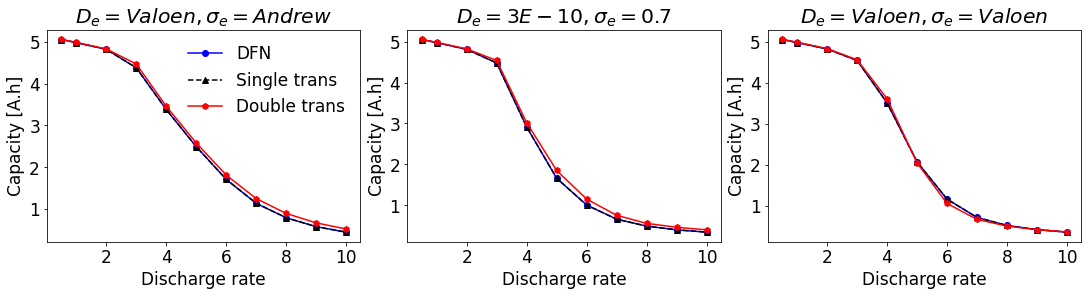

In [61]:
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
Str=[ 'DFN',  'Single trans', 'Double trans' ]
fig, axs = plt.subplots(1,3,figsize=(5*3, 4), layout='constrained')
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h']
for i in range(0,3):
    axs[0].plot(Rate_Dis_All,Andrew_All[i]['Cap_Dis_All'],color=Colors[i],linestyle=LS[i],marker = MS[i],label=Str[i])
    axs[1].plot(Rate_Dis_All,Constant_All[i]['Cap_Dis_All'],color=Colors[i],linestyle=LS[i],marker = MS[i],label=Str[i])
    axs[2].plot(Rate_Dis_All,Valoen_All[i]['Cap_Dis_All'],color=Colors[i],linestyle=LS[i],marker = MS[i],label=Str[i])
    axs[i].set_xlabel("Discharge rate")
    axs[i].set_ylabel("Capacity [A.h]")

axs[0].legend(loc='best',frameon=False,)
axs[0].set_title(r'$D_e = Valoen, \sigma_e=Andrew$',loc='center')
axs[1].set_title(r'$D_e = 3E-10, \sigma_e=0.7$',loc='center')
axs[2].set_title(r'$D_e = Valoen, \sigma_e=Valoen$',loc='center')

In [30]:
# All cases contains: 3 para * 3 models * 11 C rates = 99 solutions  # for ageing, woundn't be c rates change, so 9 models 
# ['Andrew', 'Constant', 'Valoen']
# [ 'DFN',  'Single trans', 'Double trans' ]
# [0.5,1,2,3,4,5,6,7,8,9,10];  Rate_Cha_All = [1,]

# to access Andrew - DFN - 1C:
type(Andrew_All[0]['MyDict_All'][1]['Solution'])
# to access Andrew - 'Double trans' - 1C:
type(Andrew_All[2]['MyDict_All'][1]['Solution'])
# Andrew_All 5C


pybamm.solvers.solution.Solution

In [68]:
Plot_quick(Valoen_All, 5, 8)

interactive(children=(FloatSlider(value=0.33825947584270477, description='t', max=0.42357771432979247, min=0.3…

interactive(children=(FloatSlider(value=0.33825947584270477, description='t', max=0.42357771432979247, min=0.3…

In [69]:
Plot_quick(Andrew_All, 5, 8)

interactive(children=(FloatSlider(value=0.33944104678791664, description='t', max=0.4425640765106996, min=0.33…

interactive(children=(FloatSlider(value=0.33944104678791664, description='t', max=0.4425640765106996, min=0.33…

In [70]:
Plot_quick(Constant_All, 5, 8)

interactive(children=(FloatSlider(value=0.3411676617059392, description='t', max=0.4151349923274096, min=0.341…

interactive(children=(FloatSlider(value=0.3411676617059392, description='t', max=0.4151349923274096, min=0.341…

In [ ]:
ind = 0
OCV = Sol_All[ind].cycles[0].steps[0]["X-averaged battery open circuit voltage [V]"].entries
V_CELL    = Sol_All[ind].cycles[0].steps[0]["Battery voltage [V]"].entries
eta_react = Sol_All[ind].cycles[0].steps[0]["X-averaged battery reaction overpotential [V]"].entries
eta_grad_cLi = Sol_All[ind].cycles[0].steps[0]["X-averaged battery concentration overpotential [V]"].entries
eta_grad_cEC = Sol_All[ind].cycles[0].steps[0]["X-averaged EC concentration overpotential [V]"].entries
eta_Ohmic_e = Sol_All[ind].cycles[0].steps[0]["X-averaged battery electrolyte ohmic losses [V]"].entries
eta_Ohmic_s = Sol_All[ind].cycles[0].steps[0]["X-averaged battery solid phase ohmic losses [V]"].entries
Sum_1_wo_EC = OCV+eta_react+eta_grad_cLi+eta_Ohmic_e+eta_Ohmic_s;
Sum_2_w_EC  = Sum_1_wo_EC + eta_grad_cEC;
Time_1 =  Sol_All[ind].cycles[0].steps[0]["Time [h]"].entries

fig, ax = plt.subplots(figsize=(4, 2.7), layout='constrained')
ax.plot(Time_1,V_CELL, label = 'Ternimal Voltage')
ax.plot(Time_1,Sum_1_wo_EC,  label = 'Sum_1_wo_EC')
ax.plot(Time_1,Sum_2_w_EC, '--', label = 'Sum_2_w_EC')
ax.set_title("Check plot",loc='center')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Potential [V]")
ax.legend()

fig, ax = plt.subplots(figsize=(4, 2.7), layout='constrained')
ax.plot(Time_1,V_CELL-Sum_1_wo_EC, label = 'ref')
ax.plot(Time_1,eta_grad_cEC,  label = 'grad_cEC')
ax.set_title("Check plot",loc='center')
ax.set_xlabel("Time [h]")
ax.set_ylabel("Potential [V]")
ax.legend()

In [ ]:
#label = ["Double transport wo Sol affect potential","Double transport w Sol affect potential",] 
label = ["Normal DFN"] 
output_variables3 = [
    [
        "X-averaged battery open circuit voltage [V]",
        
        "Battery voltage [V]",
    ],
    [
        "X-averaged battery reaction overpotential [V]",
        "X-averaged battery electrolyte ohmic losses [V]",
        "X-averaged battery solid phase ohmic losses [V]",
    ],
    [
        "X-averaged battery concentration overpotential [V]",
        "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    ],
]
quick_plot = pybamm.QuickPlot(
    [
        Andrew_All[i]['MyDict_All'][5]['Solution'].cycles[0].steps[1] for i in range(0,1)
    ], 
    output_variables3,label,variable_limits='tight',
    time_unit='hours',
    spatial_unit='mm',   figsize = (18,6),  #  (“m”, “mm”, or “um”)
    n_rows=1) #
quick_plot.dynamic_plot()

In [ ]:
font = {'family' : 'DejaVu Sans','size'   : 11}
mpl.rc('font', **font)
pybamm.plot_voltage_components(Sol_All[0].cycles[0].steps[0])
pybamm.plot_voltage_components(Sol_All[1].cycles[0].steps[0])
pybamm.plot_voltage_components(Sol_All[2].cycles[0].steps[0])

In [ ]:
label = ["Normal DFN","Single transport","Double transport",] 
output_variables3 = [
    "EC concentration",
    "c(EC) over c(Li+)",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
]
quick_plot = pybamm.QuickPlot(
    [
        sol.cycles[0].steps[0] for sol in Sol_All
    ], 
    output_variables3,label,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

In [ ]:
label = ["Normal DFN","Single transport","Double transport",] 
output_variables3 = [
    "Electrolyte concentration",
    "Minus div Li+ flux",
    "Li+ source term",
    "Minus div Li+ flux by diffusion",
    "Minus div Li+ flux by migration",
    "Minus div Li+ flux by solvent",
]
quick_plot = pybamm.QuickPlot(
    [
        sol.cycles[0].steps[0] for sol in Sol_All
    ],  output_variables3,label,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

In [ ]:
Plot_Last_Single_Step(Sol_2,0,0,BasicPath, Target,1,1,'False',"cool",17,200)

In [ ]:
Plot_Last_Single_Step(Sol_1,0,0,BasicPath, Target,1,1,'False',"cool",17,200)